# Test vis_paper_df

In [38]:
# !pip install ipykernel
import pandas as pd

vis_paper_df = pd.read_parquet(
    "../textprofilerbackend/.textprofiler_cache/raw_data/vis_papers/vis_papers.parquet"
)
print(vis_paper_df.head())

# vast_df = pd.read_parquet(
#     "../textprofilerbackend/.textprofiler_cache/raw_data/vast_w_id.parquet"
# )
# print(vast_df.head())


   id Conference  Year                                              Title   
0   0        Vis  2022  Photosensitive Accessibility for Interactive D...  \
1   1        Vis  2022  HetVis: A Visual Analysis Approach for Identif...   
2   2        Vis  2022  Rigel: Transforming Tabular Data by Declarativ...   
3   3        Vis  2022  BeauVis: A Validated Scale for Measuring the A...   
4   4        Vis  2022  NAS-Navigator: Visual Steering for Explainable...   

                         DOI                                         Link   
0  10.1109/TVCG.2022.3209359  http://dx.doi.org/10.1109/TVCG.2022.3209359  \
1  10.1109/TVCG.2022.3209347  http://dx.doi.org/10.1109/TVCG.2022.3209347   
2  10.1109/TVCG.2022.3209385  http://dx.doi.org/10.1109/TVCG.2022.3209385   
3  10.1109/TVCG.2022.3209390  http://dx.doi.org/10.1109/TVCG.2022.3209390   
4  10.1109/TVCG.2022.3209361  http://dx.doi.org/10.1109/TVCG.2022.3209361   

  FirstPage LastPage PaperType   
0       374      384         J  \
1     

In [39]:
vis_paper_w_df = pd.read_parquet(
    "../textprofilerbackend/.textprofiler_cache/raw_data/vis_papers/vis_papers_words.parquet"
    # "../textprofilerbackend/.textprofiler_cache/raw_data/vis_papers/vis_papers_tokens.parquet"
)
print(vis_paper_w_df.head())

            word  id
0  Accessibility   0
1     guidelines   0
2          place   0
3   restrictions   0
4             on   0


In [40]:
print(vis_paper_df.columns.tolist())
data = vis_paper_df['Abstract'].tolist()
# vis_paper_df.to_csv('./vis_paper.csv', index=False)

['id', 'Conference', 'Year', 'Title', 'DOI', 'Link', 'FirstPage', 'LastPage', 'PaperType', 'Abstract', 'AuthorNames-Deduped', 'AuthorNames', 'AuthorAffiliation', 'InternalReferences', 'AuthorKeywords', 'AminerCitationCount', 'CitationCount_CrossRef', 'PubsCited_CrossRef', 'Award', 'Abstract_text_length', 'Abstract_num_words', 'Abstract_max_word_length', 'Abstract_avg_word_length', 'Abstract_perc_special_chars']


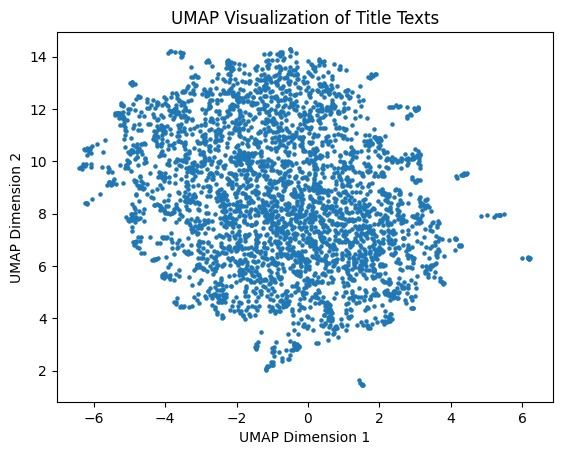

In [41]:
# !pip install umap-learn #poetry add umap-learn
import umap
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=10000)  # the maximum of max_features is 10000
tfidf_matrix = tfidf_vectorizer.fit_transform(data)

# UMAP by using TF-IDF vector
umap_embeddings = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='cosine').fit_transform(tfidf_matrix)

plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=5)
plt.title('UMAP Visualization of Title Texts')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

# Test lancedb

In [42]:
import pandas as pd
import torch
import lancedb
from pathlib import Path
import numpy as np

CACHE_PATH = "../textprofilerbackend/.textprofiler_cache/"

In [43]:
class VectorDBConnection:
    def __init__(self, database_dir="lancedb"):
        """
        embed_func: function that takes a string and returns a numpy array embedding.
        This MUST be same model as original embeddings or else comparison will not work
        """
        Path(CACHE_PATH).mkdir(parents=True, exist_ok=True)
        p = Path(CACHE_PATH) / database_dir

        print("Making new LanceDB connection")

        self.connection = lancedb.connect(p)
        self.id_cols = {}
        self.embed_funcs = {}

    def _check(self, table_name, check_conn=False, check_id=False, check_embed=False):
        if check_conn and table_name not in self.connection:
            raise ValueError(f"Table {table_name} not found in LanceDB.")

        if check_id and table_name not in self.id_cols:
            raise ValueError(f"Table {table_name} does not have an id column saved.")

        if check_embed and table_name not in self.embed_funcs:
            raise ValueError(f"Table {table_name} does not have an embedding function.")

    def add_table(
        self, table_name: str, data: pd.DataFrame, id_col_name: str, embed_func
    ):
        """
        Add a table to the database.

        Args:
            table_name (str): The name of the table.
            data (pd.DataFrame): The dataframe containing the metadata and a column called "vector" with numpy arrays per row representing the vector representation.
            id_col_name (str): The name of the column in the dataframe that contains the unique identifier for each row.
            embed_func: function that takes a string and returns a numpy array embedding for this table

        Returns:
            None
        """
        self.table = self.connection.create_table(
            table_name, data=data, mode="overwrite"
        )
        self.id_cols[table_name] = id_col_name
        self.embed_funcs[table_name] = embed_func

    def search(self, table_name: str, vector: np.array, limit: int = 20):
        """
        Find ids of KNN docs to vector
        """
        self._check(table_name, check_conn=True, check_id=True)

        id_col = self.id_cols[table_name]
        result = (
            self.connection[table_name].search(vector).limit(limit).select([id_col])
        )

        return result.to_pandas()[[id_col, "_distance"]]

    def get_embedding_from_string(self, table_name, text: str) -> np.array:
        self._check(table_name, check_embed=True)

        return self.embed_funcs[table_name](text)

    def get_embedding_from_id(self, table_name, id: str) -> np.array:
        """
        Get the embedding from the table by id
        """
        self._check(table_name, check_conn=True, check_id=True)

        df = (
            self.connection[table_name]
            .search()
            .where(f"{self.id_cols[table_name]} = {id}")
            .to_pandas()["vector"]
        )

        return df.iloc[0]

    # def get_projection_from_id(self, table_name, id: str = None) -> np.array:
    #     """
    #     Get the projection from the table by id
    #     """
    #     if id is None:
    #         self._check(table_name, check_conn=True)
            
    #         df = (
    #             self.connection[table_name]
    #             .to_pandas()
    #         )
            
    #         return df
    #     else:
    #         self._check(table_name, check_conn=True, check_id=True)

    #         df = (
    #             self.connection[table_name]
    #             .search()
    #             .where(f"{self.id_cols[table_name]} = {id}")
    #             .to_pandas() #["projection"]
    #         )

    #         return df.iloc[0]

    def get_projection_from_input(self, table_name, input: str) -> np.array:
        """
        Get the projection data
        """
        self._check(table_name, check_conn=True)
        
        df = (
            self.connection[table_name]
            .to_pandas()[["id", "projection", input]]
        )
        
        return df #pandas #(3549,)
        
        # result = pd.DataFrame({})
        # result['id'] = df["id"]
        # result['symbol'] = df["Conference"] #Todo: input
        # result['x'] = df["projection"].apply(lambda x: x[0])
        # result['y'] = df["projection"].apply(lambda x: x[1])
        # result = df.pivot_table(index='id', values=['projection', 'Conference'], aggfunc=list).reset_index()

    def get_projection_from_id(self, table_name, id: str) -> np.array:
        """
        Get the projection from the table by id
        """
        self._check(table_name, check_conn=True, check_id=True)

        df = (
            self.connection[table_name]
            .search()
            .where(f"{self.id_cols[table_name]} = {id}")
            .to_pandas() #["projection"]
        )

        return df.iloc[0]

In [44]:
import sentence_transformers

def get_embedding(col: np.ndarray, model_name):
    model = sentence_transformers.SentenceTransformer(model_name)
    e = model.encode(col)
    return e

In [45]:
from umap import UMAP

def get_projection(vector):
    reducer = UMAP(metric='cosine')
    embeddings_2d = reducer.fit_transform(vector)
    return list(embeddings_2d) #numpy->pandas

In [46]:
vectordbconn = VectorDBConnection()

table_name = "vis_papers"

print("Loading vector data...")
vis_paper_df = pd.read_parquet(
    "../textprofilerbackend/.textprofiler_cache/raw_data/vis_papers/vis_papers.parquet"
)
vis_paper_embeddings = torch.load(
    "../textprofilerbackend/.textprofiler_cache/raw_data/vis_papers/vis_papers_embeddings.pt"
)

vis_paper_df["vector"] = list(vis_paper_embeddings.numpy())
embed_func = lambda x: get_embedding(x, "all-mpnet-base-v2")

vis_paper_df["projection"] = get_projection(vis_paper_embeddings)
# vis_paper_df["projection"] = get_projection(vis_paper_df["vector"])

vectordbconn.add_table(table_name, vis_paper_df, "id", embed_func)

Making new LanceDB connection
Loading vector data...


In [47]:
print(vis_paper_df["vector"]) #list(vis_paper_embeddings.numpy()) torch->numpy->pandas
print(vis_paper_embeddings)
print(vis_paper_df["projection"])
type(vis_paper_df["projection"])

0       [-0.018565096, 0.026998717, -0.04299628, -0.02...
1       [-0.02559224, 0.06851383, -0.03908111, 0.01492...
2       [-0.030259384, -0.0031903284, -0.017378844, -0...
3       [-0.023114502, 0.06983085, -0.02306185, -0.015...
4       [-0.0041809115, 0.09560207, -0.03099676, 0.028...
                              ...                        
3544    [0.03104627, 0.014927698, -0.016123466, -0.009...
3545    [-0.03387612, -0.047240213, -0.0071494635, -0....
3546    [-0.017895978, -0.022618642, -0.017614085, 0.0...
3547    [-0.050337456, 0.016747894, -0.013995155, -0.0...
3548    [-0.002541876, 0.017837852, -0.027596775, 0.05...
Name: vector, Length: 3549, dtype: object
tensor([[-0.0186,  0.0270, -0.0430,  ...,  0.0387, -0.0176, -0.0138],
        [-0.0256,  0.0685, -0.0391,  ..., -0.0113, -0.0013,  0.0081],
        [-0.0303, -0.0032, -0.0174,  ...,  0.0170, -0.0464, -0.0170],
        ...,
        [-0.0179, -0.0226, -0.0176,  ..., -0.0003,  0.0411,  0.0018],
        [-0.0503,  0.0167, 

pandas.core.series.Series

In [48]:
vec = vectordbconn.get_embedding_from_id(table_name, 1)
r = vectordbconn.search(table_name, vec)

r.to_json(orient="records")
# r.to_dict(orient="records")

'[{"id":1,"_distance":0.0},{"id":410,"_distance":0.7563974261},{"id":385,"_distance":0.7908704877},{"id":517,"_distance":0.7967621684},{"id":642,"_distance":0.7972276211},{"id":321,"_distance":0.8293058872},{"id":643,"_distance":0.8425787687},{"id":290,"_distance":0.8438164592},{"id":386,"_distance":0.8463175297},{"id":30,"_distance":0.8532639742},{"id":543,"_distance":0.868483305},{"id":1297,"_distance":0.876093328},{"id":519,"_distance":0.8780964613},{"id":665,"_distance":0.8896995783},{"id":36,"_distance":0.8915280104},{"id":511,"_distance":0.8921464086},{"id":647,"_distance":0.8924567103},{"id":237,"_distance":0.900769949},{"id":37,"_distance":0.901024878},{"id":261,"_distance":0.9022387266}]'

In [49]:
r.to_json()

'{"id":{"0":1,"1":410,"2":385,"3":517,"4":642,"5":321,"6":643,"7":290,"8":386,"9":30,"10":543,"11":1297,"12":519,"13":665,"14":36,"15":511,"16":647,"17":237,"18":37,"19":261},"_distance":{"0":0.0,"1":0.7563974261,"2":0.7908704877,"3":0.7967621684,"4":0.7972276211,"5":0.8293058872,"6":0.8425787687,"7":0.8438164592,"8":0.8463175297,"9":0.8532639742,"10":0.868483305,"11":0.876093328,"12":0.8780964613,"13":0.8896995783,"14":0.8915280104,"15":0.8921464086,"16":0.8924567103,"17":0.900769949,"18":0.901024878,"19":0.9022387266}}'

In [50]:
vec2 = vectordbconn.get_embedding_from_string(
    table_name, "visualizing text data system"
)

r = vectordbconn.search(table_name, vec2)
r

,id,_distance
0,1593,0.603509
1,819,0.647131
2,3160,0.664667
3,1832,0.666675
4,2271,0.682674
5,2776,0.688416
6,2444,0.694812
7,3181,0.708677
8,3194,0.709930
9,1096,0.711591


In [51]:
vis_paper_df[vis_paper_df.id.isin([1593, 819, 3160])]
# vis_paper_df[vis_paper_df.id.isin([0, 1, 2])]

,id,Conference,Year,Title,DOI,Link,FirstPage,LastPage,PaperType,Abstract,...,CitationCount_CrossRef,PubsCited_CrossRef,Award,Abstract_text_length,Abstract_num_words,Abstract_max_word_length,Abstract_avg_word_length,Abstract_perc_special_chars,vector,projection
819,819,VAST,2016,TextTile: An Interactive Visualization Tool fo...,10.1109/TVCG.2016.2598447,http://dx.doi.org/10.1109/TVCG.2016.2598447,161,170,J,"We describe TextTile, a data visualization too...",...,21.0,43.0,None,804,127,15,5.338583,0.009950,"[-0.022825448, 0.027768482, -0.058228966, -0.0...","[9.225783, 8.220504]"
1593,1593,VAST,2010,Understanding text corpora with multiple facets,10.1109/VAST.2010.5652931,http://dx.doi.org/10.1109/VAST.2010.5652931,99,106,C,Text visualization becomes an increasingly mor...,...,36.0,29.0,None,1113,172,16,5.476744,0.020665,"[-0.012490144, -0.013318891, -0.05780364, 0.00...","[9.652254, 8.475426]"
3160,3160,InfoVis,1996,Visualizing the results of multimedia Web sear...,10.1109/INFVIS.1996.559219,http://dx.doi.org/10.1109/INFVIS.1996.559219,64,"65, 122",M,Search engines are very useful because they al...,...,10.0,2.0,None,414,69,14,5.014493,0.021739,"[0.0064505064, -0.017319938, -0.033198442, 0.0...","[8.793579, 8.512704]"


In [52]:
proj = vectordbconn.get_projection_from_input(table_name, "Conference")
proj
# proj.shape
# type(proj)
# proj.to_json()
# proj.to_json(orient="records")
# result = proj.to_dict(orient="records")
result = proj.set_index('id').to_dict(orient='index')
result
# type(result)
json_result = pd.Series(result).to_json()
json_result
proj['id'] = proj['id'].astype(str)
proj['projection'] = proj['projection'].apply(lambda x: x.tolist())
result = proj.set_index('id').to_dict(orient='index')
result

{'0': {'projection': [6.692628860473633, 6.887288570404053],
  'Conference': 'Vis'},
 '1': {'projection': [9.288437843322754, 6.767776966094971],
  'Conference': 'Vis'},
 '2': {'projection': [6.677506446838379, 8.730168342590332],
  'Conference': 'Vis'},
 '3': {'projection': [6.58580207824707, 7.092108249664307],
  'Conference': 'Vis'},
 '4': {'projection': [9.331921577453613, 6.545707702636719],
  'Conference': 'Vis'},
 '5': {'projection': [7.628882884979248, 8.131196975708008],
  'Conference': 'Vis'},
 '6': {'projection': [6.396193981170654, 6.533298015594482],
  'Conference': 'Vis'},
 '7': {'projection': [6.712714195251465, 8.851944923400879],
  'Conference': 'Vis'},
 '8': {'projection': [6.196430683135986, 7.9305009841918945],
  'Conference': 'Vis'},
 '9': {'projection': [6.421885013580322, 7.201985836029053],
  'Conference': 'Vis'},
 '10': {'projection': [5.035912036895752, 8.483522415161133],
  'Conference': 'Vis'},
 '11': {'projection': [7.334558010101318, 6.329214572906494],
  

In [53]:
proj = vectordbconn.get_projection_from_id(table_name, 819)
# proj = vectordbconn.get_projection_from_id(table_name, 0)
proj
# proj.shape
# type(proj)
# proj.to_dict()
# proj.to_json(orient="records")
# proj.to_dict(orient="records")
result = proj.to_dict()
result
# type(result)


{'id': 819,
 'Conference': 'VAST',
 'Year': 2016,
 'Title': 'TextTile: An Interactive Visualization Tool for Seamless Exploratory Analysis of Structured Data and Unstructured Text',
 'DOI': '10.1109/TVCG.2016.2598447',
 'Link': 'http://dx.doi.org/10.1109/TVCG.2016.2598447',
 'FirstPage': '161',
 'LastPage': '170',
 'PaperType': 'J',
 'Abstract': 'We describe TextTile, a data visualization tool for investigation of datasets and questions that require seamless and flexible analysis of structured data and unstructured text. TextTile is based on real-world data analysis problems gathered through our interaction with a number of domain experts and provides a general purpose solution to such problems. The system integrates a set of operations that can interchangeably be applied to the structured as well as to unstructured text part of the data to generate useful data summaries. Such summaries are then organized in visual tiles in a grid layout to allow their analysis and comparison. We valid

In [54]:
print(vis_paper_df["projection"].shape)

vdf = pd.DataFrame({})
vdf['Conference'] = vis_paper_df['Conference']
# vdf['Umap_x'] = vis_paper_df['projection'][:, 0]
# vdf['Umap_y'] = vis_paper_df['projection'][:, 1]
vdf['Umap_x'] = vis_paper_df['projection'].apply(lambda x: x[0])
vdf['Umap_y'] = vis_paper_df['projection'].apply(lambda x: x[1])
vdf

(3549,)


,Conference,Umap_x,Umap_y
0,Vis,6.692629,6.887289
1,Vis,9.288438,6.767777
2,Vis,6.677506,8.730168
3,Vis,6.585802,7.092108
4,Vis,9.331922,6.545708
...,...,...,...
3544,Vis,2.272462,7.266072
3545,Vis,2.233223,6.093081
3546,Vis,-0.191196,8.301171
3547,Vis,5.333733,7.660918


# Test Mosaic

In [55]:
# !pip install mosaic-widget
import pandas as pd
import yaml
from mosaic_widget import MosaicWidget

weather = pd.read_csv(
    "https://uwdata.github.io/mosaic-datasets/data/seattle-weather.csv",
    parse_dates=["date"],
)
print(weather)

spec = {
    "params": {
        "click": {"select": "single"},
        "domain": ["sun", "fog", "drizzle", "rain", "snow"],
        "colors": ["#e7ba52", "#a7a7a7", "#aec7e8", "#1f77b4", "#9467bd"],
    },
    "vconcat": [
        {
            "hconcat": [
                {
                    "plot": [
                        {
                            "mark": "dot",
                            "data": {"from": "weather", "filterBy": "$click"},
                            "x": {"dateMonthDay": "date"},
                            "y": "temp_max",
                            "fill": "weather",
                            "r": "precipitation",
                            "opacity": 0.7,
                        },
                        {"select": "intervalX", "as": "$range"},
                        {"select": "highlight", "by": "$range", "fill": "#eee"},
                        {"legend": "color", "as": "$click", "columns": 1},
                    ],
                    "xyDomain": "Fixed",
                    "xTickFormat": "%b",
                    "colorDomain": "$domain",
                    "colorRange": "$colors",
                    "rDomain": "Fixed",
                    "rRange": [2, 10],
                    "width": 800,
                }
            ]
        },
        {
            "plot": [
                {
                    "mark": "barX",
                    "data": {"from": "weather"},
                    "x": {"count": None},
                    "y": "weather",
                    "fill": "#f5f5f5",
                },
                {
                    "mark": "barX",
                    "data": {"from": "weather", "filterBy": "$range"},
                    "x": {"count": None},
                    "y": "weather",
                    "fill": "weather",
                    "order": "weather",
                },
                {"select": "toggleY", "as": "$click"},
                {"select": "highlight", "by": "$click"},
            ],
            "xDomain": "Fixed",
            "yDomain": "$domain",
            "yLabel": None,
            "colorDomain": "$domain",
            "colorRange": "$colors",
            "width": 800,
        },
    ],
}


MosaicWidget(spec, data={"weather": weather})

           date  precipitation  temp_max  temp_min  wind  weather
0    2012-01-01            0.0      12.8       5.0   4.7  drizzle
1    2012-01-02           10.9      10.6       2.8   4.5     rain
2    2012-01-03            0.8      11.7       7.2   2.3     rain
3    2012-01-04           20.3      12.2       5.6   4.7     rain
4    2012-01-05            1.3       8.9       2.8   6.1     rain
...         ...            ...       ...       ...   ...      ...
1456 2015-12-27            8.6       4.4       1.7   2.9     rain
1457 2015-12-28            1.5       5.0       1.7   1.3     rain
1458 2015-12-29            0.0       7.2       0.6   2.6      fog
1459 2015-12-30            0.0       5.6      -1.0   3.4      sun
1460 2015-12-31            0.0       5.6      -2.1   3.5      sun

[1461 rows x 6 columns]


MosaicWidget(spec={'params': {'click': {'select': 'single'}, 'domain': ['sun', 'fog', 'drizzle', 'rain', 'snow…

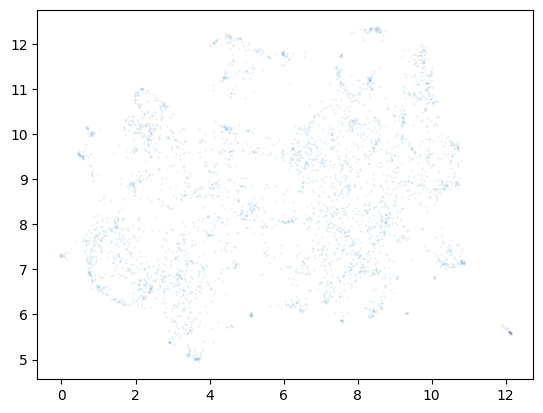

In [56]:
from umap import UMAP

reducer = UMAP(metric='cosine')
embeddings_2d = reducer.fit_transform(vis_paper_embeddings)

import matplotlib.pyplot as plt
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=0.1, alpha=0.2)
plt.show()

In [57]:
# !pip install mosaic-widget
import pandas as pd
import yaml
from mosaic_widget import MosaicWidget

spec = {
  "params": {
    "bandwidth": 40,
    "thresholds": 10
  },
  "vconcat": [
    {
      "hconcat": [
        {
          "input": "slider",
          "label": "Bandwidth (σ)",
          "as": "$bandwidth",
          "min": 1,
          "max": 100
        },
        {
          "input": "slider",
          "label": "Thresholds",
          "as": "$thresholds",
          "min": 2,
          "max": 20
        }
      ]
    },
    {
      "plot": [
        {
          "mark": "raster",
          "data": {
            "from": "df"
          },
          "x": "Umap_x",
          "y": "Umap_y",
          "fill": "Conference",
          "bandwidth": "$bandwidth"
        },
        {
          "mark": "contour",
          "data": {
            "from": "df"
          },
          "x": "Umap_x",
          "y": "Umap_y",
          "stroke": "Conference",
          "bandwidth": "$bandwidth",
          "thresholds": "$thresholds"
        },
        {
          "mark": "dot",
          "data": {
            "from": "df"
          },
          "x": "Umap_x",
          "y": "Umap_y",
          "fill": "black",
          "r": 1
        }
      ],
      "xAxis": "bottom",
      "xLabelAnchor": "center",
      "yAxis": "right",
      "yLabelAnchor": "center",
      "margins": {
        "top": 5,
        "bottom": 30,
        "left": 5,
        "right": 50
      },
      "width": 700,
      "height": 480
    }
  ]
}

MosaicWidget(spec, data={"df": vdf})

MosaicWidget(spec={'params': {'bandwidth': 40, 'thresholds': 10}, 'vconcat': [{'hconcat': [{'input': 'slider',…

/Users/ylchang/.pyenv/versions/3.10.13/envs/tp3.10.13/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


In [58]:
vdf['Conference'].unique()

array(['Vis', 'VAST', 'InfoVis', 'SciVis'], dtype=object)

In [59]:
'''
pan & zoom
'''
# !pip install mosaic-widget
import pandas as pd
import yaml
from mosaic_widget import MosaicWidget

spec = {
  "params": {
    # "bandwidth": 1,
    # "thresholds": 10
  },
  "vconcat": [
    # {
    #   "hconcat": [
    #     {
    #       "input": "slider",
    #       "label": "Bandwidth (σ)",
    #       "as": "$bandwidth",
    #       "min": 1,
    #       "max": 100
    #     },
    #     {
    #       "input": "slider",
    #       "label": "Thresholds",
    #       "as": "$thresholds",
    #       "min": 2,
    #       "max": 20
    #     }
    #   ]
    # },
    {
      "name": "umapplot",
      "plot": [
        {
            "mark": "frame"
        },
        # {
        #   "mark": "raster",
        #   "data": {
        #     "from": "df"
        #   },
        #   "x": "Umap_x",
        #   "y": "Umap_y",
        #   "fill": "Conference",
        #   "bandwidth": "$bandwidth",
        # },
        # {
        #   "mark": "contour",
        #   "data": {
        #     "from": "df"
        #   },
        #   "x": "Umap_x",
        #   "y": "Umap_y",
        #   "stroke": "Conference",
        #   "bandwidth": "$bandwidth",
        #   "thresholds": "$thresholds",
        # },
        {
          "mark": "dot",
          "data": {
            "from": "df"
          },
          "x": "Umap_x",
          "y": "Umap_y",
          "fill": "Conference",
        #   "symbol": "Conference",
          "r": 1,
          "clip": True
        },
        {
            "select": "panZoom",
            "x": "$xs",
            "y": "$ys",
        },
        # {
        #   "legend": "symbol",
        #   "for": "umapplot",
        #   "columns": 1
        # }
      ],
    #   "grid": True,
      "xAxis": "bottom",
      "xLabelAnchor": "center",
      "yAxis": "right",
      "yLabelAnchor": "center",
      "margins": {
        "top": 5,
        "bottom": 30,
        "left": 5,
        "right": 50
      },
      "width": 700,
      "height": 480
    }
  ]
}

MosaicWidget(spec, data={"df": vdf})

MosaicWidget(spec={'params': {}, 'vconcat': [{'name': 'umapplot', 'plot': [{'mark': 'frame'}, {'mark': 'dot', …

In [60]:
'''
input + pan & zoom
'''
# !pip install mosaic-widget
import pandas as pd
import yaml
from mosaic_widget import MosaicWidget

spec = {
  "params": {
    # "bandwidth": 1,
    # "thresholds": 10
  },
  "vconcat": [
    {
      "input": "menu",
      "label": "Conference(Type)",
      "as": "$query",
      "from": "df",
      "column": "Conference",
      "value": "Vis"
    },
    {
      "vspace": 10
    },
    {
      "name": "umapplot",
      "plot": [
        {
            "mark": "frame"
        },
        {
          "mark": "dot",
          "data": {
            "from": "df",
            "filterBy": "$query"
          },
          "x": "Umap_x",
          "y": "Umap_y",
          "fill": "Conference",
          "r": 1,
          "clip": True
        },
        {
            "select": "panZoom",
            "x": "$xs",
            "y": "$ys",
        },
      ],
      "xAxis": "bottom",
      "xLabelAnchor": "center",
      "yAxis": "right",
      "yLabelAnchor": "center",
      "margins": {
        "top": 5,
        "bottom": 30,
        "left": 5,
        "right": 50
      },
      "width": 700,
      "height": 480
    }
  ]
}

MosaicWidget(spec, data={"df": vdf})

MosaicWidget(spec={'params': {}, 'vconcat': [{'input': 'menu', 'label': 'Conference(Type)', 'as': '$query', 'f…

In [61]:
'''
brush
'''
# !pip install mosaic-widget
import pandas as pd
import yaml
from mosaic_widget import MosaicWidget

spec = {
  "params": {
    "brush": {
      "select": "single"
    }
  },
  "vconcat": [
    {
      "name": "umapplot",
      "plot": [
        {
            "mark": "frame",
            "stroke": "#ccc"
        },
        {
          "mark": "dot",
          "data": {
            "from": "df"
          },
          "x": "Umap_x",
          "y": "Umap_y",
          "fill": "Conference",
          "r": 1,
          # "clip": True
        },
        # {
        #     "select": "panZoom",
        #     "x": "$xs",
        #     "y": "$ys",
        # },
        {
          "select": "intervalXY",
          "as": "$brush"
        },
        {
          "select": "highlight",
          "by": "$brush",
          "opacity": 0.1
        }
      ],
      "xAxis": "bottom",
      "xLabelAnchor": "center",
      "yAxis": "right",
      "yLabelAnchor": "center",
      "margins": {
        "top": 5,
        "bottom": 30,
        "left": 5,
        "right": 50
      },
      "width": 700,
      "height": 480
    }
  ]
}

MosaicWidget(spec, data={"df": vdf})

MosaicWidget(spec={'params': {'brush': {'select': 'single'}}, 'vconcat': [{'name': 'umapplot', 'plot': [{'mark…

In [62]:
'''
cross-filtering?
'''
# !pip install mosaic-widget
import pandas as pd
import yaml
from mosaic_widget import MosaicWidget

spec = {
  "params": {
    # "bandwidth": 1,
    # "thresholds": 10
  },
  "vconcat": [
    {
      "input": "menu",
      "label": "Conference(Type)",
      "as": "$query",
      "from": "df",
      "column": "Conference",
      "value": "Vis"
    },
    {
      "vspace": 10
    },
    {
      "hconcat": [
        {
          "plot": [
            {
              "mark": "rectY",
              "data": {
                "from": "df"
              },
              "x": {
                "bin": "Umap_x"
              },
              "y": {
                "count": None
              },
              "fill": "steelblue",
              "inset": 0.5
            },
            {
              "select": "intervalX",
              "as": "$query"
            }
          ],
          "margins": {
            "left": 5,
            "right": 5,
            "top": 30,
            "bottom": 0
          },
          "xDomain": "Fixed",
          "xAxis": "top",
          "yAxis": None,
          "xLabelAnchor": "center",
          "width": 700,
          "height": 70
        },
        {
          "hspace": 80
        }
      ]
    },
    {
      "name": "umapplot",
      "plot": [
        {
            "mark": "frame"
        },
        {
          "mark": "dot",
          "data": {
            "from": "df",
            "filterBy": "$query"
          },
          "x": "Umap_x",
          "y": "Umap_y",
          "fill": "Conference",
          "r": 1,
          "clip": True
        },
        {
            "select": "panZoom",
            "x": "$xs",
            "y": "$ys",
        },
      ],
      "xAxis": "bottom",
      "xLabelAnchor": "center",
      "yAxis": "right",
      "yLabelAnchor": "center",
      "margins": {
        "top": 5,
        "bottom": 30,
        "left": 5,
        "right": 50
      },
      "width": 700,
      "height": 480
    }
  ]
}

MosaicWidget(spec, data={"df": vdf})

MosaicWidget(spec={'params': {}, 'vconcat': [{'input': 'menu', 'label': 'Conference(Type)', 'as': '$query', 'f…

/Users/ylchang/.pyenv/versions/3.10.13/envs/tp3.10.13/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


# Test duckdb

In [71]:
import duckdb
CACHE_PATH = "../textprofilerbackend/.textprofiler_cache/"
con = duckdb.connect(database=':memory:', read_only=False)

def load_dataset(dataset_name: str, dataset_path: str):
    """
    Loads a dataset into the database

    Args:
        dataset_name: name of the dataset
        dataset_path: path to parquet file
    """
    p = Path(CACHE_PATH) / dataset_path

    # TODO: should maybe use the register function, especially for arrow data like parquet?
    #  See: https://duckdb.org/docs/archive/0.9.2/api/python/data_ingestion#dataframes--arrow-tables

    con.execute(
        f"CREATE TABLE IF NOT EXISTS '{dataset_name}' AS (SELECT * FROM read_parquet('{str(p)}'));"
    )

load_dataset("vast2021", "raw_data/vast_w_id.parquet")
load_dataset("vast2021_word", "raw_data/vast_word_w_id.parquet")
load_dataset("vis_papers", "raw_data/vis_papers/vis_papers.parquet")
load_dataset(
    "vis_papers_words", "raw_data/vis_papers/vis_papers_words.parquet"
)

tables = con.execute("SHOW TABLES").fetchall()
print(tables)

for table_info in tables:
    table_name = table_info[0]
    print(f"Table: {table_name}")
    
    columns = con.execute(f"PRAGMA table_info({table_name})").fetchall()
    print("Columns:")
    for column_info in columns:
        column_name = column_info[1]
        column_type = column_info[2]
        print(f"  {column_name}: {column_type}")
    
    print()

[('vast2021',), ('vast2021_word',), ('vis_papers',), ('vis_papers_words',)]
Table: vast2021
Columns:
  id: BIGINT
  type: VARCHAR
  author: VARCHAR
  message: VARCHAR
  latitude: DOUBLE
  longitude: DOUBLE
  location: VARCHAR
  date: TIMESTAMP
  message_text_length: BIGINT
  message_num_words: BIGINT
  message_max_word_length: BIGINT
  message_avg_word_length: DOUBLE
  message_perc_special_chars: DOUBLE
  message_dist_from_mean_embed_all-mpnet-base-v2: FLOAT
  message_outlier_score_ECOD_all-mpnet-base-v2: DOUBLE
  message_outlier_score_IForest_all-mpnet-base-v2: DOUBLE
  message_cluster_id_comm: VARCHAR
  message_cluster_id_hdb: VARCHAR
  message_pii_count: BIGINT

Table: vast2021_word
Columns:
  id: BIGINT
  word: VARCHAR

Table: vis_papers
Columns:
  id: BIGINT
  Conference: VARCHAR
  Year: BIGINT
  Title: VARCHAR
  DOI: VARCHAR
  Link: VARCHAR
  FirstPage: VARCHAR
  LastPage: VARCHAR
  PaperType: VARCHAR
  Abstract: VARCHAR
  AuthorNames-Deduped: VARCHAR
  AuthorNames: VARCHAR
  Aut

In [72]:
import torch
from umap import UMAP
vis_paper_embeddings = torch.load(
    "../textprofilerbackend/.textprofiler_cache/raw_data/vis_papers/vis_papers_embeddings.pt"
)
def get_projection(vector):
    reducer = UMAP(metric='cosine')
    embeddings_2d = reducer.fit_transform(vector)
    return embeddings_2d
proj = get_projection(vis_paper_embeddings) #or vis_paper_df["vector"] #(3549,)
print(proj.shape)
proj

(3549, 2)


array([[ 7.8412876 ,  7.1216116 ],
       [10.639511  ,  7.6423507 ],
       [ 7.5359597 ,  8.911467  ],
       ...,
       [ 0.56267446,  7.7228103 ],
       [ 6.3144236 ,  7.70304   ],
       [ 2.4724452 , 10.3965025 ]], dtype=float32)

In [73]:
# proj = proj.tolist()
# df = pd.DataFrame(proj, columns=['proj_x', 'proj_y'])
# df['id'] = range(len(df))

df = pd.DataFrame(proj, columns=['x', 'y']).assign(id=range(len(proj)))
df

,x,y,id
0,7.841288,7.121612,0
1,10.639511,7.642351,1
2,7.535960,8.911467,2
3,7.704302,7.334709,3
4,10.742184,7.538107,4
...,...,...,...
3544,3.130997,6.813426,3544
3545,3.379289,5.752572,3545
3546,0.562674,7.722810,3546
3547,6.314424,7.703040,3547


In [74]:
con.execute(f"ALTER TABLE vis_papers ADD COLUMN px DOUBLE")
con.execute(f"ALTER TABLE vis_papers ADD COLUMN py DOUBLE")


con.execute("""
UPDATE vis_papers
SET
    px = p.x,
    py = p.y
FROM
    df p
WHERE
    vis_papers.id = p.id
""")

In [76]:
tables = con.execute("SHOW TABLES").fetchall()
print(tables)

for table_info in tables:
    table_name = table_info[0]
    print(f"Table: {table_name}")
    
    columns = con.execute(f"PRAGMA table_info({table_name})").fetchall()
    print("Columns:")
    for column_info in columns:
        column_name = column_info[1]
        column_type = column_info[2]
        print(f"  {column_name}: {column_type}")
    
    print()

[('vast2021',), ('vast2021_word',), ('vis_papers',), ('vis_papers_words',)]
Table: vast2021
Columns:
  id: BIGINT
  type: VARCHAR
  author: VARCHAR
  message: VARCHAR
  latitude: DOUBLE
  longitude: DOUBLE
  location: VARCHAR
  date: TIMESTAMP
  message_text_length: BIGINT
  message_num_words: BIGINT
  message_max_word_length: BIGINT
  message_avg_word_length: DOUBLE
  message_perc_special_chars: DOUBLE
  message_dist_from_mean_embed_all-mpnet-base-v2: FLOAT
  message_outlier_score_ECOD_all-mpnet-base-v2: DOUBLE
  message_outlier_score_IForest_all-mpnet-base-v2: DOUBLE
  message_cluster_id_comm: VARCHAR
  message_cluster_id_hdb: VARCHAR
  message_pii_count: BIGINT

Table: vast2021_word
Columns:
  id: BIGINT
  word: VARCHAR

Table: vis_papers
Columns:
  id: BIGINT
  Conference: VARCHAR
  Year: BIGINT
  Title: VARCHAR
  DOI: VARCHAR
  Link: VARCHAR
  FirstPage: VARCHAR
  LastPage: VARCHAR
  PaperType: VARCHAR
  Abstract: VARCHAR
  AuthorNames-Deduped: VARCHAR
  AuthorNames: VARCHAR
  Aut